In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Tensorflow imports

# for building model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Flatten, GlobalMaxPooling1D, Dense, Dropout

# for Padding
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences

# for Tokenization 
from tensorflow.keras.preprocessing.text import Tokenizer

# NLTK imports
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For regular expressions
import re

# For data preprocessing
from string import punctuation, digits

In [6]:
train_df = pd.read_csv("Corona_NLP_train.csv", encoding="Latin-1")
test_df = pd.read_csv("Corona_NLP_test.csv", encoding="Latin-1")

print(f"train dataset shape >> {train_df.shape}")
print(f"test dataset shape >> {test_df.shape}")

train dataset shape >> (41157, 6)
test dataset shape >> (3798, 6)


In [7]:
# Creat new dataset (which will consist from 2 columns: label, data)

def data_label_split(dataset):
    data = dataset['OriginalTweet']
    label = dataset['Sentiment']
    return data,label

train_data,train_label = data_label_split(train_df)
test_data,test_label = data_label_split(test_df)

train = pd.DataFrame({
    'label':train_label,
    'data':train_data
})

test = pd.DataFrame({
    'label':test_label,
    'data':test_data
})

# Define function which will make new labels

def reassign_label(x):
    if x == "Extremely Positive" or x == "Positive":
        return 1
    elif x =="Extremely Negative" or x =="Negative":
        return -1
    elif x =="Neutral":
        return 0

train.label = train.label.apply(lambda x:reassign_label(x))
test.label = test.label.apply(lambda x:reassign_label(x))

In [8]:
def remove_punctuation(s):
    list_punctuation = list(punctuation)
    for i in list_punctuation:
        s = s.replace(i,'')
    return s.lower()

def clean_sentence(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r'(\W)\1{2,}', r'\1', sentence) 
    sentence = re.sub(r'(\w)\1{2,}', r'\1\1', sentence)
    sentence = re.sub(r'(?P<url>https?://[^\s]+)', '', sentence) # remove URL adresses
    sentence = re.sub(r"\@(\w+)", '', sentence) # remove usernames
    sentence = re.sub(r"\#(\w+)", '', sentence) # remove hashtags
    sentence = re.sub(r"\$(\w+)", '', sentence) # remove cashtags
    sentence = sentence.replace("-",' ')
    tokens = sentence.split()
    tokens = [remove_punctuation(w) for w in tokens] # remove punctuations
    stop_words = set(stopwords.words('english')) # remove stopwords
    tokens = [w for w in tokens if not w in stop_words]
    remove_digits = str.maketrans('', '', digits)
    tokens = [w.translate(remove_digits) for w in tokens]
    tokens = [w.strip() for w in tokens]
    tokens = [w for w in tokens if w!=""]
    tokens = ' '.join(tokens)
    return tokens

In [9]:
train.data = train.data.apply(lambda sentence:clean_sentence(sentence))
test.data = test.data.apply(lambda sentence:clean_sentence(sentence))

In [10]:
def rem_latin_a(sentences):
    sentences = sentences.replace("â", "")
    return sentences

train.data = train.data.apply(lambda sentences:rem_latin_a(sentences))
test.data = test.data.apply(lambda sentences:rem_latin_a(sentences))

In [11]:
train['data'].replace('', np.nan, inplace=True)
test['data'].replace('', np.nan, inplace=True)

In [12]:
# Originally there were 41157 rows, now it has become 41106. The training dataset was reduced by 51 lines.
train.dropna(subset=['data'], inplace=True)

# Originally there were 3798 lines, now it has become 3795. The test dataset was reduced by 3 lines.
test.dropna(subset=['data'], inplace=True)

In [13]:
# Train data
train_data = train.data
train_label = train.label

# Test data
test_data = test.data
test_label = test.label

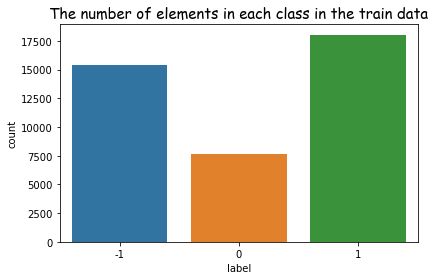

In [14]:
sns.countplot(x=train_label)
plt.title('The number of elements in each class in the train data', fontdict={'fontname': 'Comic Sans MS', 'fontsize': 15})
plt.tight_layout()
plt.show()

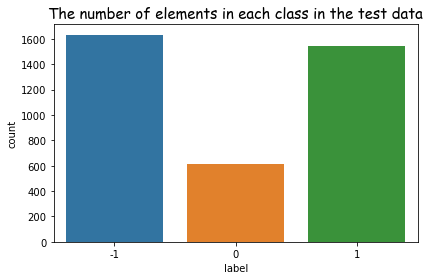

In [15]:
sns.countplot(x=test_label)
plt.title('The number of elements in each class in the test data', fontdict={'fontname': 'Comic Sans MS', 'fontsize': 15})
plt.tight_layout()
plt.show()

In [16]:
train_label = pd.get_dummies(train_label)
test_label = pd.get_dummies(test_label)

In [17]:
train_label

,-1,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,1,0,0
5,0,0,1
...,...,...,...
41152,0,1,0
41153,1,0,0
41154,0,0,1
41155,0,1,0


In [18]:
lemmatizer = WordNetLemmatizer()

# Function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# Function below is necessery to find lemma of each word
def lemmatize_sentence(de_punct_sent):
    # Tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(de_punct_sent))
    # Tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            # If there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:
            # else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [25]:
train_lem = [lemmatize_sentence(i) for i in train_data]
test_lem = [lemmatize_sentence(i) for i in test_data]

In [20]:
nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\AVINASH\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [22]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\AVINASH\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [24]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\AVINASH\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

In [26]:
samples_1 = train_lem
samples_2 = test_lem

tokenizer = Tokenizer(num_words=25000) # 25 000 most frequently used words
tokenizer.fit_on_texts(samples_1) # Creat an index of all words from training data

# Convert strings to integer index lists

# After that, we pass the ready-made (from the line above) indexes for all words from train
train_data = tokenizer.texts_to_sequences(samples_1)

# And for test. So, we should get the same word indexes in the two texts
test_data = tokenizer.texts_to_sequences(samples_2)

word_index = tokenizer.word_index # Find out the calculated index of words
print('Found %s unique tokens.' % len(word_index))

Found 31903 unique tokens.


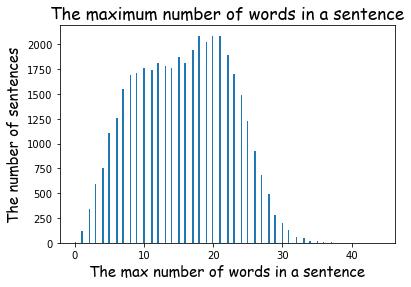

In [27]:
lens =  [len(s) for s in train_data]

plt.title('The maximum number of words in a sentence', fontdict={'fontname': 'Comic Sans MS', 'fontsize': 17})
plt.xlabel('The max number of words in a sentence', fontdict={'fontname': 'Comic Sans MS', 'fontsize': 15})
plt.ylabel('The number of sentences', fontdict={'fontname': 'Comic Sans MS', 'fontsize': 15})
plt.hist(lens,bins=200)
plt.show()

In [28]:
maxlen = 40 # maximal length of sentences

# Convert lists of integers to a two-dimensional tensor 
# with integers and with a shape (samples, max. length)

train_data = preprocessing.sequence.pad_sequences(train_data, maxlen=maxlen, padding='post', truncating='post') 
test_data = preprocessing.sequence.pad_sequences(test_data, maxlen=maxlen, padding='post', truncating='post')

In [29]:
embedding_dim = 32 # Dimension of the dense embedding.

vocab_inp_size = len(word_index) + 1 # Size of the vocabulary

hidden_size = 256

In [30]:
model = Sequential() 

# The Embedding layer is necessery in order to convert words (in out case from integers) to vectors
model.add(Embedding(input_dim = vocab_inp_size, output_dim = embedding_dim, input_length = maxlen))

# Apply Dropout to use recurrent decimation to combat overfitting 
model.add(LSTM(hidden_size, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)) 

# Use Flatten() or GlobalMaxPooling1D() to convert 3D output to 2D.
# It allows you to add one or more Dense layers to your model 
model.add(Flatten()) # or model.add(GlobalMaxPooling1D())

#model.add(Dense(64, activation='relu'))#as experiment we tried to add one additional layer,but it is not give as higher accuracy
#model.add(Dropout(0.4))

model.add(Dense(3, activation='softmax'))#activation function for classification

model.summary()

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['categorical_accuracy']) 

history = model.fit(train_data, train_label, epochs=10, batch_size=128, validation_split=0.2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 32)            1020928   
_________________________________________________________________
lstm (LSTM)                  (None, 40, 256)           295936    
_________________________________________________________________
flatten (Flatten)            (None, 10240)             0         
_________________________________________________________________
dense (Dense)                (None, 3)                 30723     
Total params: 1,347,587
Trainable params: 1,347,587
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
257/257 [==============================] - 63s 243ms/step - loss: 0.4878 - categorical_accuracy: 0.6219 - val_loss: 0.3853 - val_categorical_accuracy: 0.7479
Epoch 2/10
257/257 [==============================] - 61s 239ms/step - loss

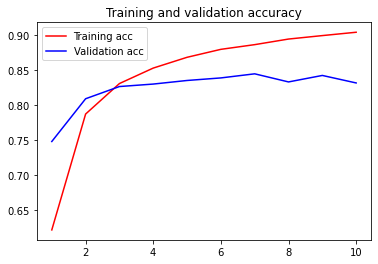

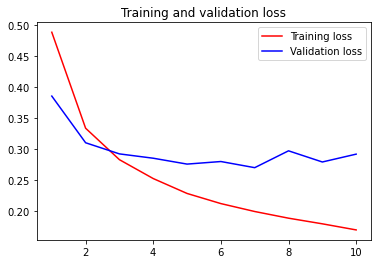

In [31]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [32]:
model.evaluate(test_data,test_label)

119/119 [==============================] - 3s 23ms/step - loss: 0.3132 - categorical_accuracy: 0.8200


[0.3132161796092987, 0.8200263381004333]